In [42]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cv2

import os

In [43]:
class Object:
    def __init__(self, class_name, img):
        self.class_name = class_name
        self.img = img

In [44]:
H = 256

In [45]:
original_gray_dataset = []

for subdir, _, files in os.walk('dataset'):
    for fname in files:
        class_name = subdir.partition('/')[2]
        img = cv2.imread(f"{subdir}/{fname}", cv2.IMREAD_GRAYSCALE)
        original_gray_dataset.append(Object(class_name, cv2.resize(img, (H, H))))

In [46]:
linear_gradient = np.tile(np.linspace(0,1,H), (H,1))

In [47]:
MEAN_SZ = 3
mean_filter = np.tile(1/(MEAN_SZ**2), (MEAN_SZ, MEAN_SZ))

In [48]:
def augment_img(img):
    return (img,
            cv2.normalize((linear_gradient * img).astype(np.uint8), None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U),
            cv2.normalize((np.log2(1 + img/255) * 255).astype(np.uint8), None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U),
            cv2.normalize(((2**(img/255) - 1) * 255).astype(np.uint8), None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U),
            cv2.filter2D(src=img, ddepth=-1, kernel=mean_filter))

In [49]:
augmented_dataset = []
for obj in original_gray_dataset:
    for aug_img in augment_img(obj.img):        
        augmented_dataset.append(Object(obj.class_name, aug_img))

In [50]:
clahe = cv2.createCLAHE()
normalized_dataset = []
for obj in augmented_dataset:
    normalized_dataset.append(Object(obj.class_name, clahe.apply(obj.img)))

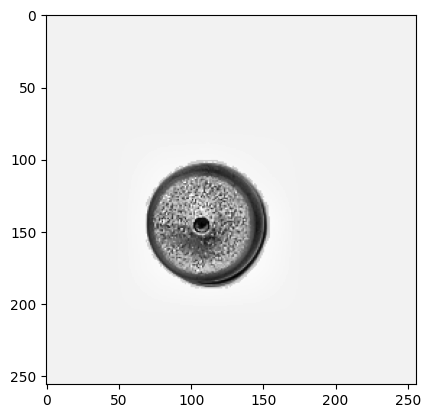

In [172]:
plt.imshow(normalized_dataset[0].img, cmap='gray')
plt.show()

In [52]:
bin_dataset = []
for obj in normalized_dataset:
    _, thresh = cv2.threshold(cv2.GaussianBlur(obj.img, (11,11), 0), 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    bin_dataset.append(Object(obj.class_name, thresh))

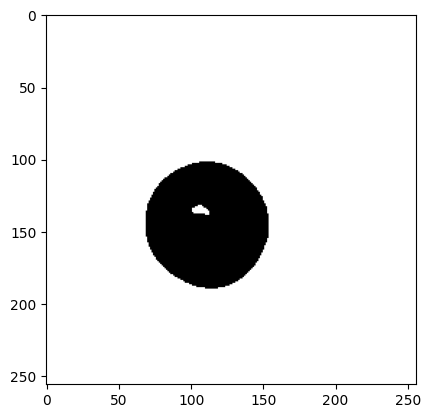

In [55]:
plt.imshow(bin_dataset[0].img, cmap='gray')
plt.show()

In [56]:
edges_dataset = []
for obj in bin_dataset:
    # edges = cv2.Canny(obj.img,30,100)
    edges = cv2.Canny(cv2.GaussianBlur(obj.img, (3,3), 0), threshold1=255/3, threshold2=255)
    edges_dataset.append(Object(obj.class_name, edges))

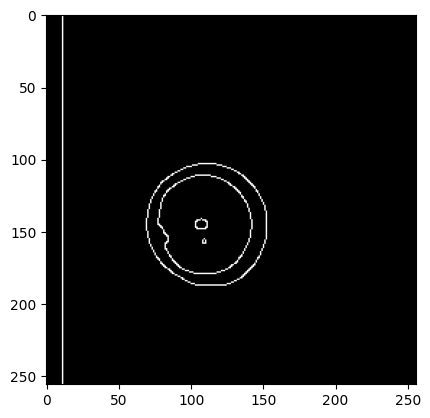

In [58]:
plt.imshow(edges_dataset[1].img, cmap='gray')
plt.show()

In [59]:
contour_dataset = []
for obj in edges_dataset:
    new_img = np.zeros_like(obj.img)
    contour, _ = cv2.findContours(obj.img, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    
    for cnt in contour:
        cv2.drawContours(new_img, [cnt], 0, 255, -1)
    
    rect = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    dilation = cv2.dilate(new_img, rect, iterations=2)
    closing = cv2.morphologyEx(dilation, cv2.MORPH_CLOSE, rect)

    contour_dataset.append(Object(obj.class_name, closing))

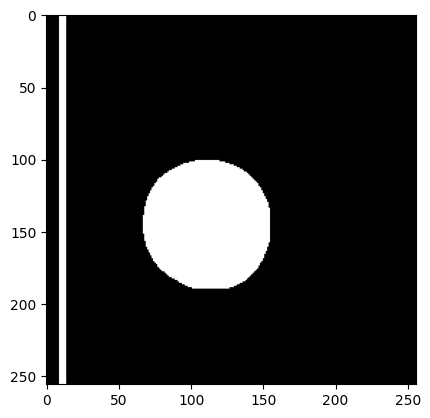

In [61]:
plt.imshow(contour_dataset[1].img, cmap='gray')
plt.show()

In [64]:
seg_dataset = []
objs_per_class = {}

for obj in contour_dataset:
    new_img = np.zeros_like(obj.img)
    contour, _ = cv2.findContours(obj.img,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
    
    cnt = max(contour, key=cv2.contourArea)
    cv2.drawContours(new_img, [cnt], 0, 255, -1)
    
    new_obj = Object(obj.class_name, new_img)
    seg_dataset.append((new_obj, cnt))

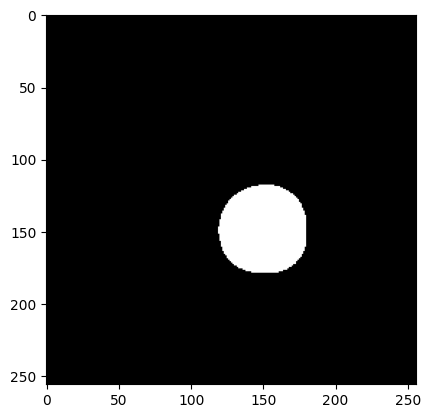

In [140]:
plt.imshow(seg_dataset[5][0].img, cmap='gray')
plt.show()

In [74]:
def get_feret_box(img_seg):
    x_in, y_in = np.where(img_seg == 255)
    box_min = (min(y_in), min(x_in))
    box_max = (max(y_in), max(x_in))

    return box_min, box_max

In [75]:
feret_box_imgs = []

for i in range(len(augmented_dataset)):
    img_copy = augmented_dataset[i].img.copy()
    box_min, box_max = get_feret_box(seg_dataset[i][0].img)
    cv2.rectangle(img_copy, box_min, box_max, 0, thickness=2)
    feret_box_imgs.append(img_copy)

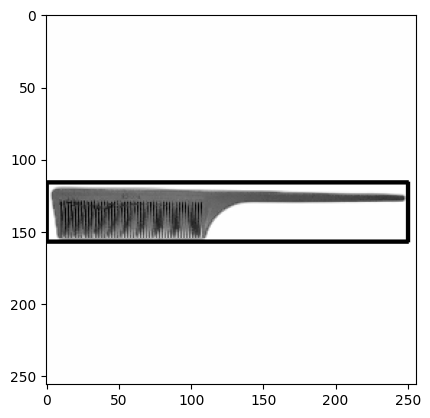

In [155]:
plt.imshow(feret_box_imgs[333], cmap='gray')
plt.show()

In [147]:
def get_features(cnt):
    area = cv2.contourArea(cnt)

    M = cv2.moments(cnt)
    cx = int(M["m10"] / M["m00"])
    cy = int(M["m01"] / M["m00"])
    
    rect = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(rect)
    box = np.intp(box)
    area_norm_box = area/cv2.contourArea(box)

    (x,y), r = cv2.minEnclosingCircle(cnt)
    area_norm_circle = area/(np.pi * r**2)

    cx_norm = abs(cx - x)
    cy_norm = abs(cy - y)
    
    w, h = rect[1]
    stretch = max(w/h, h/w)

    return area_norm_box, area_norm_circle, cx_norm, cy_norm, stretch

In [156]:
get_features(seg_dataset[333][1])

(0.6009756097560975,
 0.1252717954942353,
 33.94000244140625,
 5.5,
 6.097560975609756)

In [157]:
objs_per_class = {}

for i in range(len(seg_dataset)):
    obj = seg_dataset[i]
    if not objs_per_class.get(obj[0].class_name):
        objs_per_class[obj[0].class_name] = []
    objs_per_class[obj[0].class_name].append(get_features(obj[1]))

In [158]:
from sklearn.model_selection import train_test_split

test_size = 0.2
X_train, X_test, y_train, y_test = [], [], [], []

for class_name in objs_per_class.keys():
    objs = objs_per_class[class_name]
    
    X_tr, X_te, y_tr, y_te = train_test_split(
        objs, 
        [class_name] * len(objs), 
        test_size=test_size, shuffle=True, 
        random_state=42)

    X_train += X_tr
    X_test += X_te
    y_train += y_tr
    y_test += y_te

In [159]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

In [166]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [167]:
y_pred = clf.predict(X_test)

In [168]:
y_pred

array(['Cruz', 'Caneta', 'Pente', 'Pente', 'Tampa', 'Caneta', 'Cruz',
       'Pente', 'Tampa', 'Cruz', 'Caixa', 'Caneta', 'Pente', 'Caixa',
       'Tampa', 'Tampa', 'Caneta', 'Caneta', 'Cruz', 'Pente', 'Caixa',
       'Pente', 'Caixa', 'Caneta', 'Caneta', 'Tampa', 'Pente', 'Caneta',
       'Caneta', 'Caixa', 'Tampa', 'Pente', 'Tampa', 'Cruz', 'Cruz',
       'Tampa', 'Cruz', 'Caneta', 'Tampa', 'Caixa', 'Caneta', 'Caneta',
       'Caixa', 'Caneta', 'Cruz', 'Tampa', 'Caneta', 'Tampa', 'Tampa',
       'Cruz', 'Tampa', 'Caixa', 'Tampa', 'Pente', 'Cruz', 'Caixa',
       'Caixa', 'Pente', 'Cruz', 'Cruz', 'Cruz', 'Pente', 'Caixa',
       'Tampa', 'Caixa', 'Cruz', 'Pente', 'Cruz', 'Caixa', 'Pente',
       'Caneta', 'Caixa', 'Pente', 'Pente', 'Caixa', 'Cruz', 'Caneta',
       'Tampa', 'Cruz', 'Caneta', 'Tampa', 'Caneta', 'Caixa', 'Caixa',
       'Caixa', 'Caneta', 'Pente', 'Pente', 'Tampa', 'Cruz'], dtype='<U6')

In [169]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Caixa       1.00      1.00      1.00        18
      Caneta       0.95      1.00      0.97        18
        Cruz       1.00      1.00      1.00        18
       Pente       1.00      0.94      0.97        18
       Tampa       1.00      1.00      1.00        18

    accuracy                           0.99        90
   macro avg       0.99      0.99      0.99        90
weighted avg       0.99      0.99      0.99        90



In [170]:
confusion_matrix(y_test, y_pred)

array([[18,  0,  0,  0,  0],
       [ 0, 18,  0,  0,  0],
       [ 0,  0, 18,  0,  0],
       [ 0,  1,  0, 17,  0],
       [ 0,  0,  0,  0, 18]])

In [171]:
from joblib import dump
dump(clf, 'clf.joblib')

['clf.joblib']